In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.utils as utils

In [5]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [6]:
visium_config = {
    'dtype': 'multiplex',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'encoder_dim': 256,
        'kl_scaler': .001,
        'recon_scaler': 1.,
        'neigh_scaler': .1,
        'codebook_size': 100,
        'decoder_dims': (256, 100, 30,)
    },
    'learner_kwargs': {
        'scale': .1,
        'contrast_pct': None,
#         'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 1,
        'device': 'cpu',
#         'channels': channels,
        'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 500,
#         'save_dir': chkpt_dir       
    },
}

In [7]:
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/testing/mushroom/{case}_vae_vq_codex_cb30/outputs')

config = yaml.safe_load(open(config_fp))

chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [8]:
visium_config['sections'] = config
visium_config['train_kwargs']['save_dir'] = chkpt_dir
visium_config['chkpt_filepath'] = os.path.join(chkpt_dir, 'final.pt')

In [9]:
mushroom = Mushroom.from_config(visium_config)

INFO:root:using device: cpu
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's2', 's4', 's5']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized


In [10]:
mushroom.embed_sections()

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

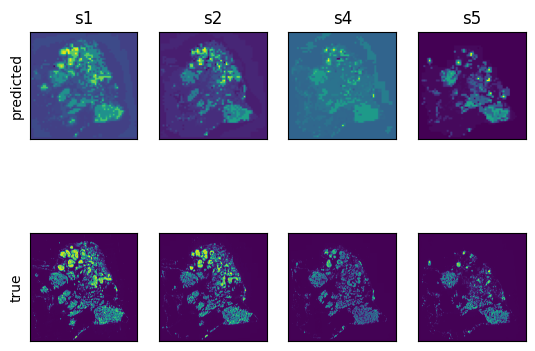

In [11]:
mushroom.display_predicted_pixels(channel='Pan-Cytokeratin')

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

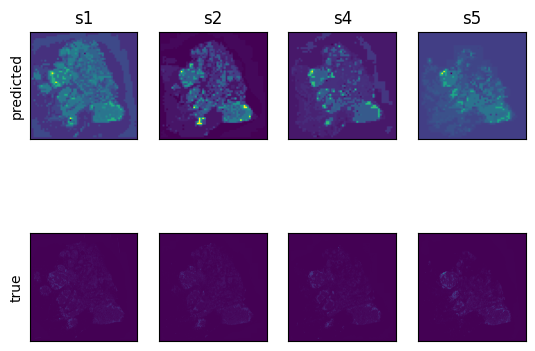

In [12]:
mushroom.display_predicted_pixels(channel='CD45')

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

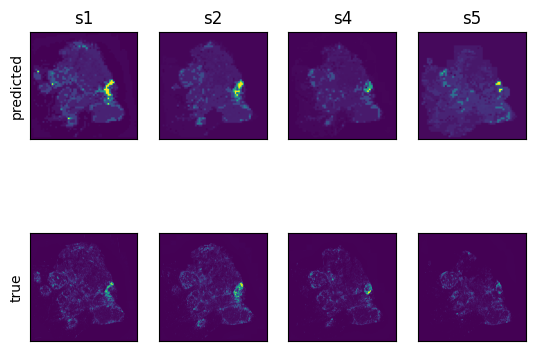

In [13]:
mushroom.display_predicted_pixels(channel='HLA-DR')

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

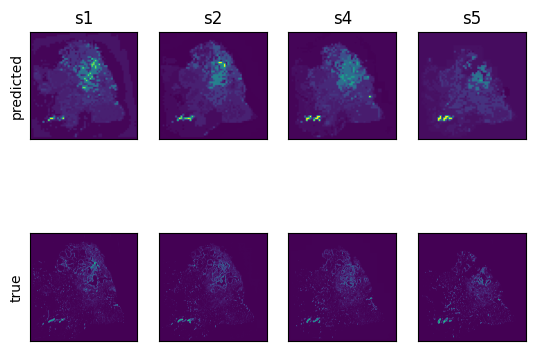

In [14]:
mushroom.display_predicted_pixels(channel='SMA')

In [15]:
cluster_ids = mushroom.recon_cluster_ids.cpu().detach().numpy().astype(int)

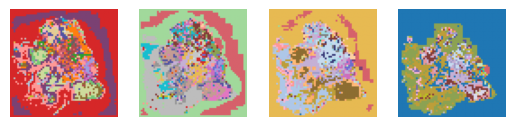

In [16]:
from mushroom.visualization.utils import display_labeled_as_rgb
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c') + sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(cluster_ids))
for ax, x in zip(axs, cluster_ids):
    x = display_labeled_as_rgb(x, cmap=cmap)
    ax.imshow(x)
    ax.axis('off')

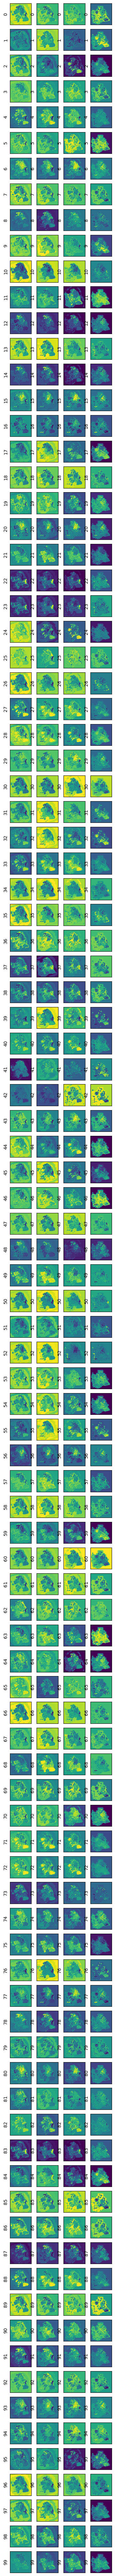

In [17]:
nrows, ncols = mushroom.cluster_sims.shape[1], mushroom.cluster_sims.shape[0]
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
for c in range(ncols):
    for r in range(nrows):
        ax = axs[r, c]
        ax.imshow(mushroom.cluster_sims[c, r])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(r, rotation=90)


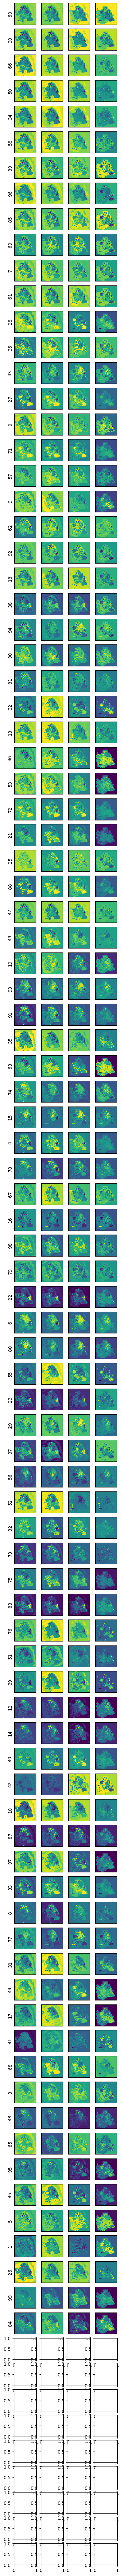

In [18]:
order = [c for c, _ in Counter(cluster_ids.flatten()).most_common()]
nrows, ncols = mushroom.cluster_sims.shape[1], mushroom.cluster_sims.shape[0]
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
for c in range(ncols):
    for r, clust in enumerate(order):
        ax = axs[r, c]
        ax.imshow(mushroom.cluster_sims[c, clust])
        ax.set_xticks([])
        ax.set_yticks([])
        if c == 0: ax.set_ylabel(clust, rotation=90)


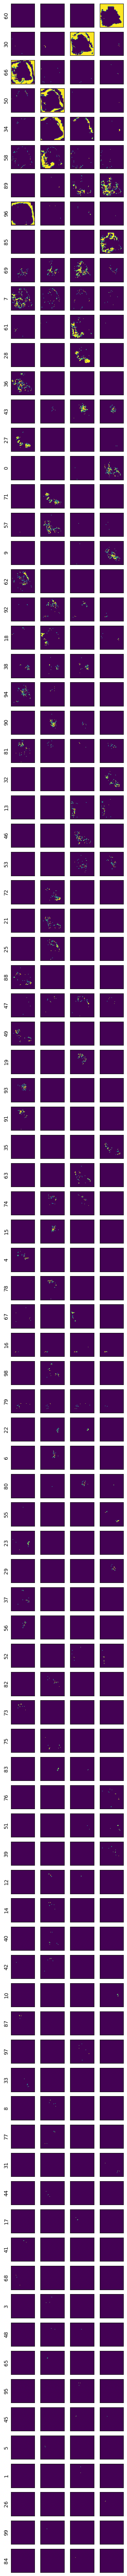

In [19]:
order = [c for c, _ in Counter(cluster_ids.flatten()).most_common()]
nrows, ncols = len(order), cluster_ids.shape[0]
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
for c in range(ncols):
    for r, clust in enumerate(order):
        ax = axs[r, c]
        ax.imshow(cluster_ids[c]==clust)
        ax.set_xticks([])
        ax.set_yticks([])
        if c == 0: ax.set_ylabel(clust, rotation=90)


In [20]:
counts = Counter(cluster_ids.flatten())

In [21]:
counts[82]

17

#### gene set based

In [22]:
exp_df = mushroom.get_cluster_intensities()
exp_df

Bap1      CD31      CD45      CD68       CD8      CK14      CK19  \
0   0.082081  0.074226  0.110369 -0.076703  0.068298 -0.044682 -0.013677   
1   0.205308  0.241480  0.181252  0.173013  0.044801 -0.086732  0.010588   
3   0.015829  0.230746  0.187124  0.061914  0.205358 -0.010158  0.092013   
4   0.432771  0.332892  0.270903  0.744780 -0.013366  0.094563  0.998412   
5  -0.033459  0.135615 -0.007679 -0.004626 -0.015277 -0.024457 -0.063273   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.538605  0.058480  0.202917  0.609380 -0.119764  0.103034  0.652628   
96  0.039833 -0.121973 -0.045061  0.030018  0.000613 -0.000906 -0.042861   
97  1.000000  0.004109  0.440709  1.000000 -0.032078  0.102868  1.000000   
98 -0.007586  0.345776  0.197529  0.026233  0.165635 -0.006206  0.015764   
99  0.282554  0.330848  0.582717  0.018756  0.408766 -0.029973  0.003974   

       COX6c      DAPI        ER  ...      Her2      Ki67       MGP  PLAT/tPA  \
0   0.123920  0.091266 -0.316533  ...  0.026398  0.040814  0.039176  0.066096   
1   1.000000  0.047919  0.016061  ...  0.004402 -0.376731  0.046203  0.733587   
3   0.301445  0.215677  0.196351  ...  0.091143  0.065576  0.005559  0.140364   
4   0.898697  0.484774  0.917178  ...  1.000000  0.917681  0.255028  0.201543   
5   0.002672  0.100616 -0.020995  ... -0.025045  0.030309 -0.001847 -0.035554   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  0.073147  0.344486  0.750686  ...  0.747888  0.250722  0.586716  0.900882   
96 -0.017668 -0.169150 -0.075692  ...  0.027704 -0.046430 -0.027829 -0.021146   
97  0.191107  0.444895  0.526381  ...  1.000000  1.000000  0.218583  1.000000   
98  0.254064  0.403568  0.182315  ...  0.055179  0.046517  0.063482  0.184721   
99  0.416687  0.489132 -0.065759  ...  0.065769  0.252545  0.017510  0.142503   

          PR  Pan-Cytokeratin  Podoplanin       SMA  Vimentin      cKit  
0  -0.059726        -0.070165   -0.016109  0.084616  0.373071 -0.100413  
1  -0.041915        -0.155429   -0.033244  0.095882  0.323181  0.728778  
3   0.140600         0.094777    0.283294  0.026267  0.384022  0.130173  
4   0.996530         0.746361    0.100210  0.041468 -0.029590  0.668031  
5  -0.019782        -0.025934   -0.128101  0.032021  0.213258  0.000309  
..       ...              ...         ...       ...       ...       ...  
95  0.420734         1.000000    0.204278 -0.012557  0.008421  1.000000  
96 -0.199227        -0.025595    0.214458 -0.025924 -0.132018  0.029540  
97  1.000000         0.823224   -0.024593  0.009451 -0.016970  0.599204  
98  0.248478         0.022457    0.467478  0.070826  0.405957  0.007556  
99  0.022673         0.038472    0.002370  0.061893  0.382764 -0.154720  

[91 rows x 24 columns]

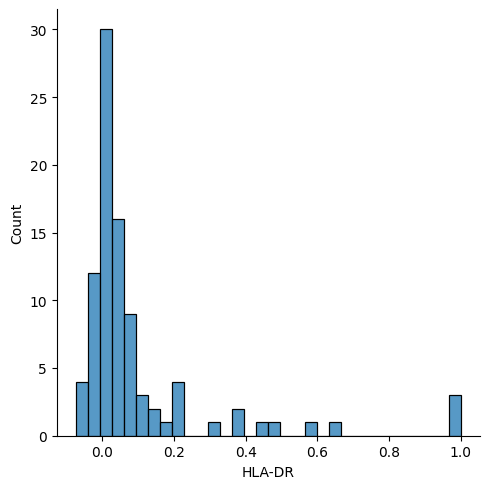

In [23]:
gene = 'HLA-DR'
sns.displot(exp_df[gene])

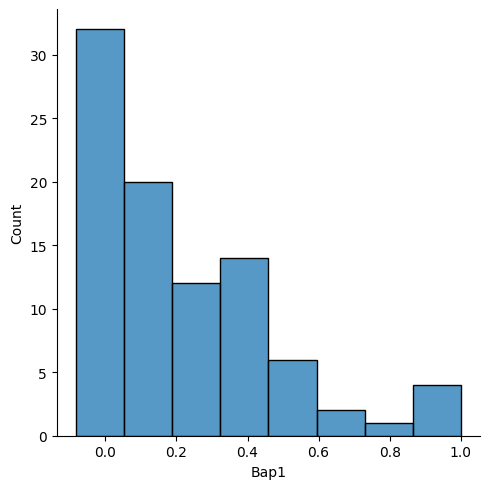

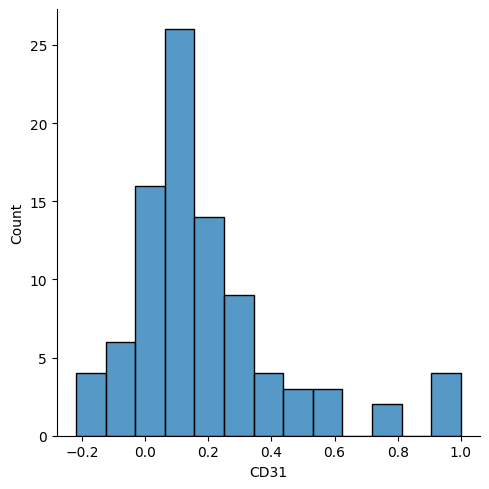

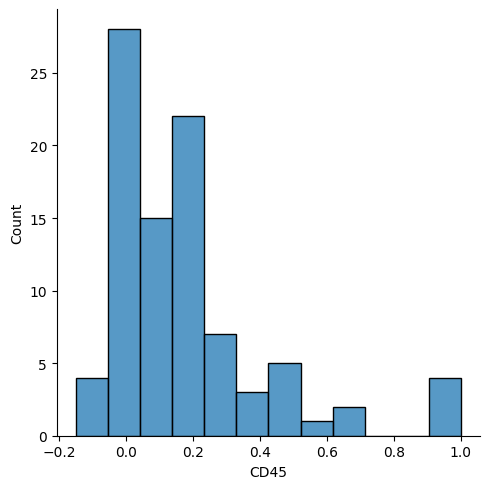

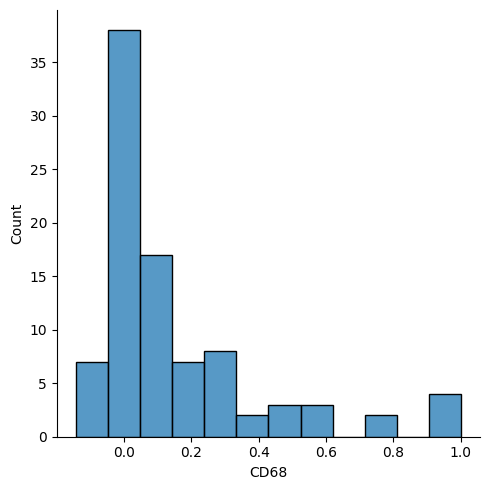

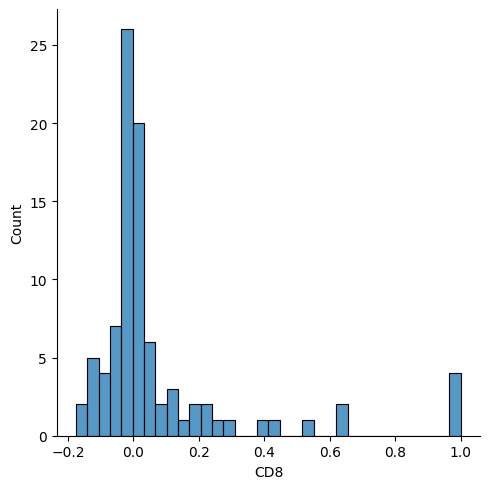

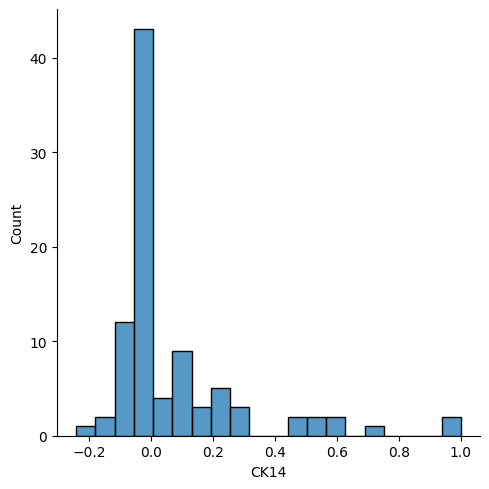

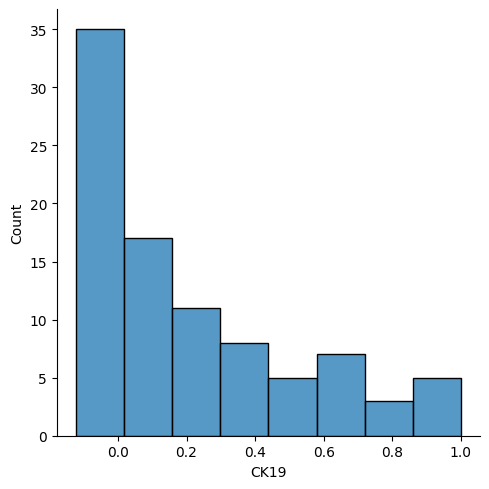

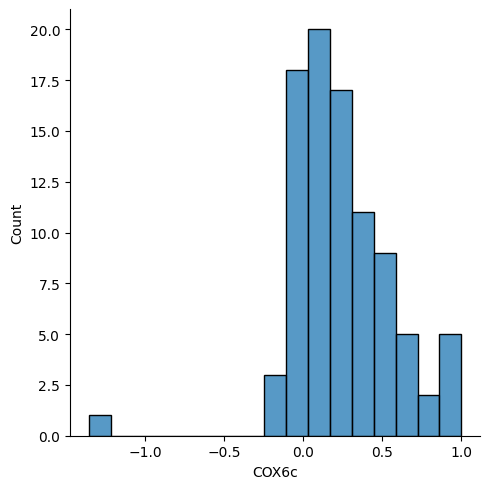

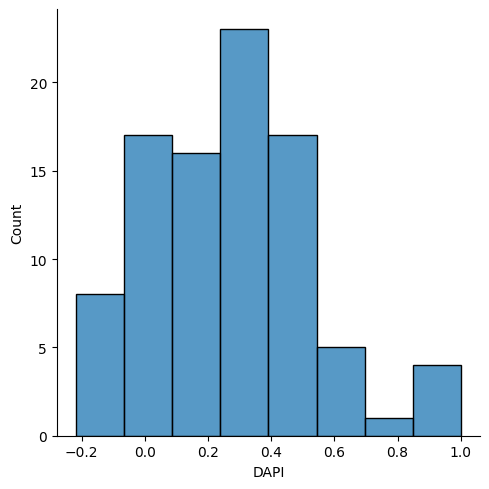

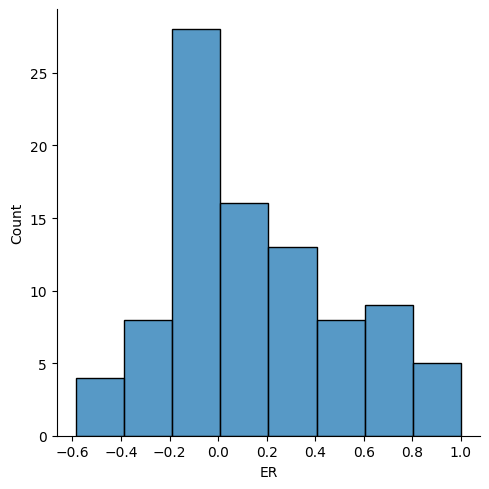

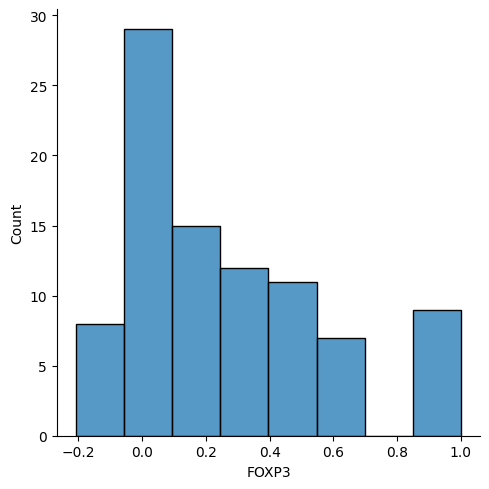

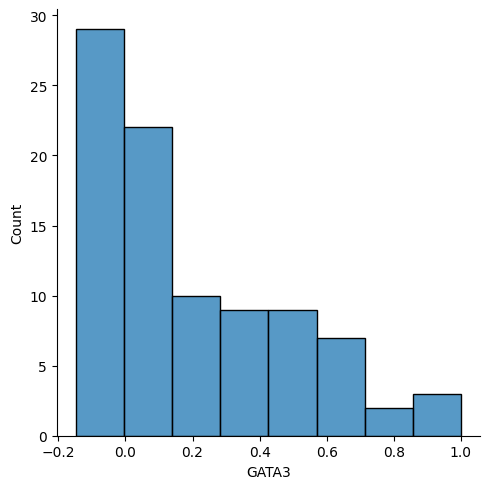

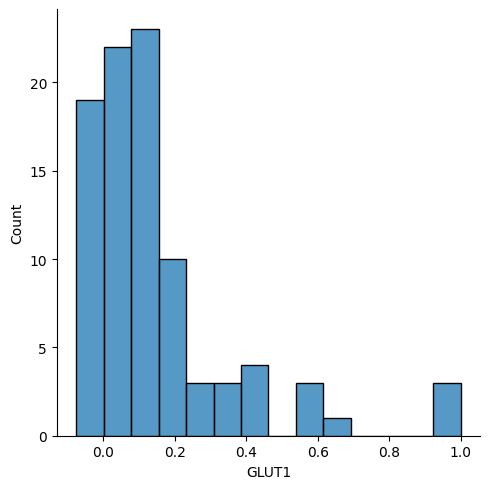

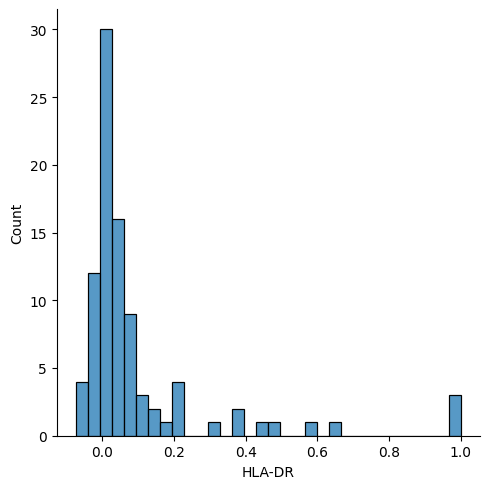

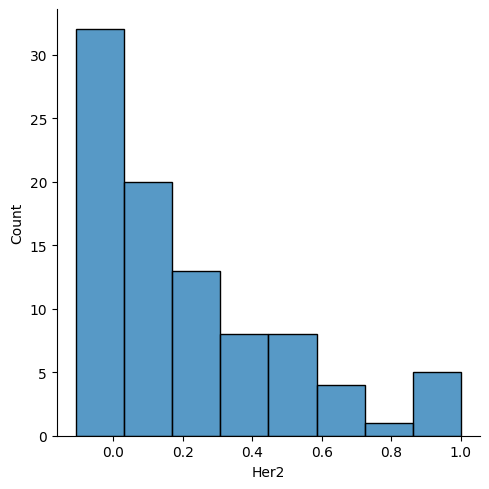

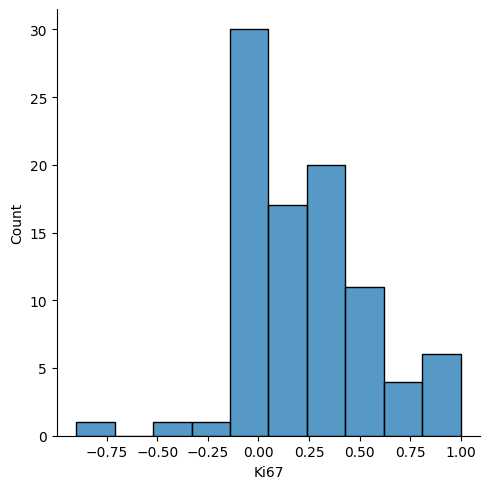

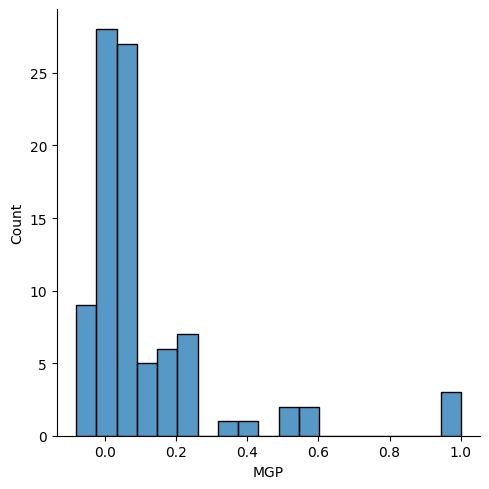

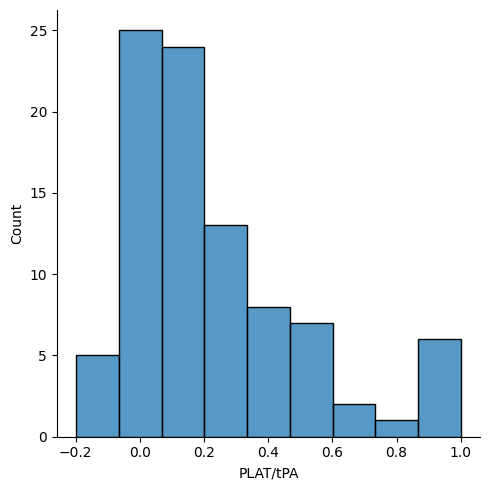

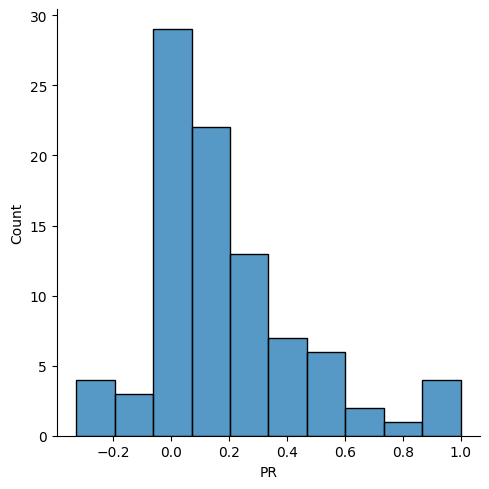

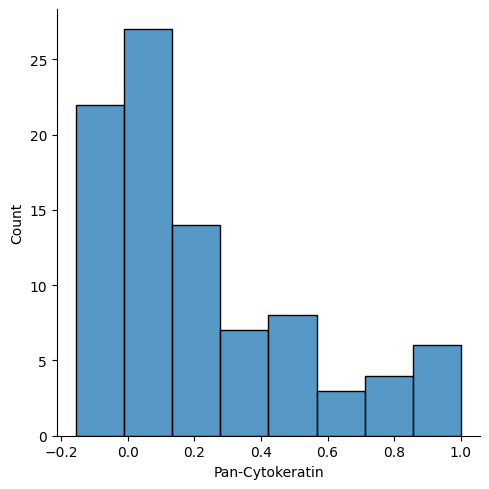

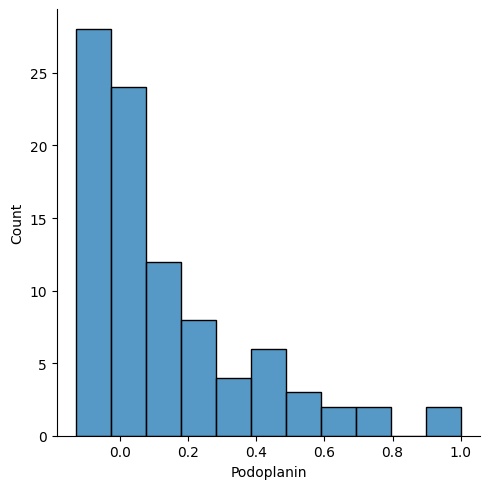

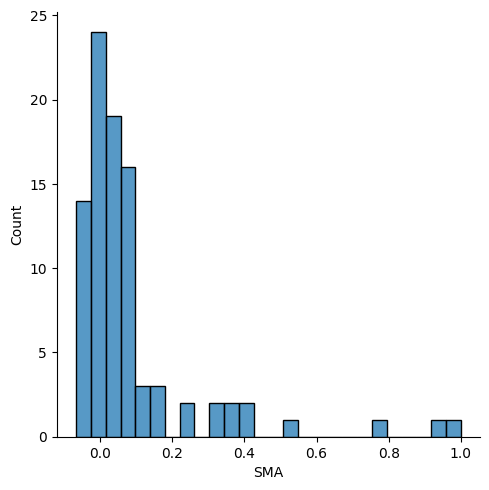

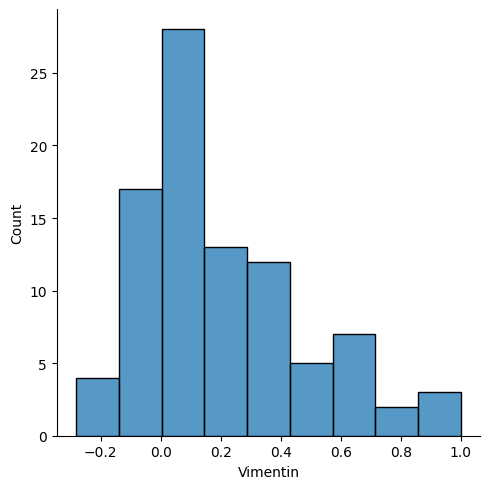

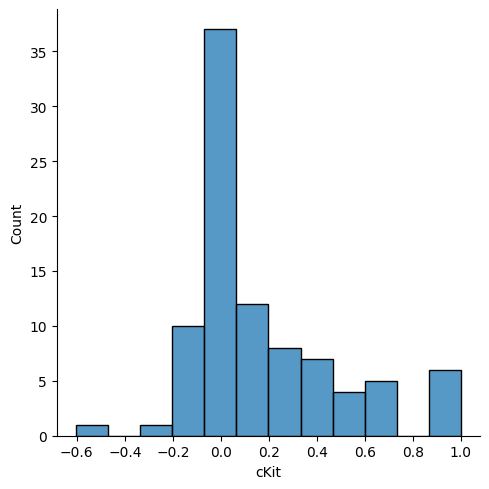

In [24]:
for gene in mushroom.learner.channels:
    sns.displot(exp_df[gene])
    plt.show()

array([[<Axes: ylabel='0.05'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.07'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.08'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.10'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.12'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.13'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.15'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.17'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.18'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.20'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

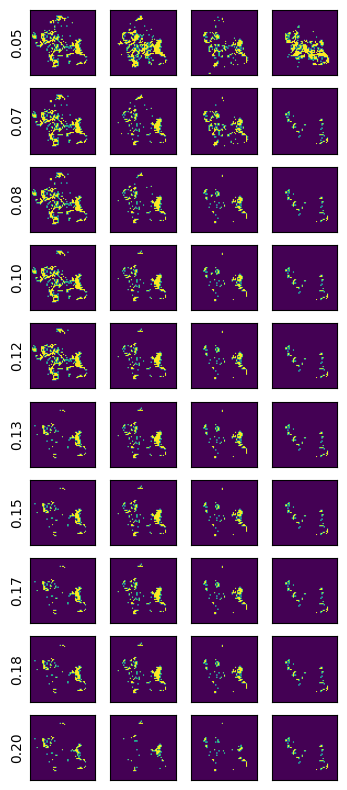

In [25]:
cuts = np.linspace(.05, .2, 10)
utils.display_thresholds(cuts, cluster_ids, exp_df, 'HLA-DR')

array([[<Axes: ylabel='0.00'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.05'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.11'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.16'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.21'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.26'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.32'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.37'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.42'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.47'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.53'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.58'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.63'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.68'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.74'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.79'>, <Axes: >, <Axes: >, <Axes: >],
       [

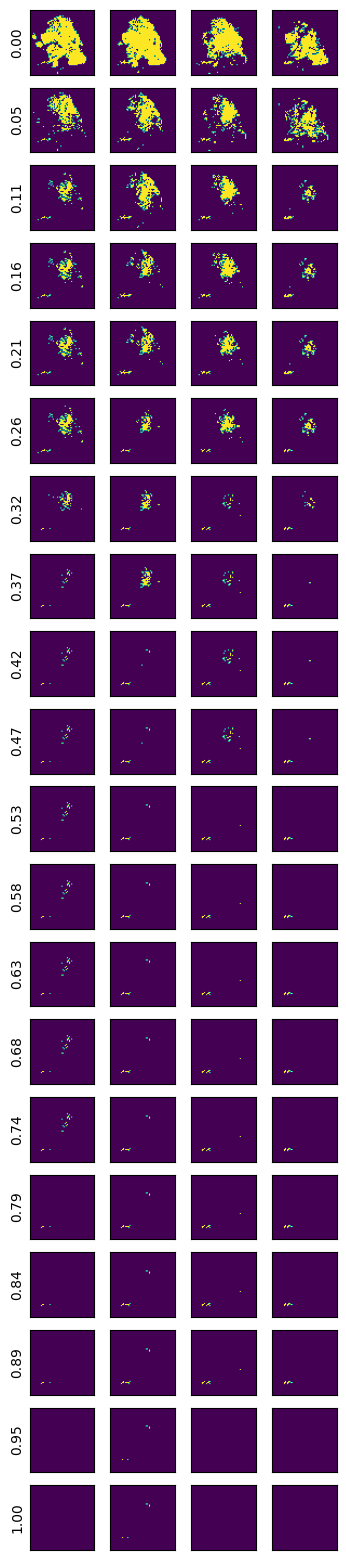

In [26]:
cuts = np.linspace(.0, 1., 20)
utils.display_thresholds(cuts, cluster_ids, exp_df, 'SMA')

In [40]:
data = []
for cluster in exp_df.index.to_list():
    row = np.count_nonzero(cluster_ids==cluster, axis=(1, 2)).astype(float)
    total = row.sum()
    row /= total
    row = row.tolist()
    row.append(total)
    data.append(row)
count_df = pd.DataFrame(data=data, columns=['s0', 's1', 's2', 's3', 'total'], index=exp_df.index.to_list())
count_df

s0        s1        s2        s3  total
0   0.000000  0.000000  0.011976  0.988024  167.0
1   0.000000  0.000000  1.000000  0.000000    2.0
3   0.000000  1.000000  0.000000  0.000000    3.0
4   1.000000  0.000000  0.000000  0.000000   38.0
5   0.000000  1.000000  0.000000  0.000000    2.0
..       ...       ...       ...       ...    ...
95  0.000000  0.000000  1.000000  0.000000    3.0
96  0.976492  0.005425  0.016275  0.001808  553.0
97  0.000000  0.000000  1.000000  0.000000    7.0
98  0.000000  1.000000  0.000000  0.000000   32.0
99  0.000000  1.000000  0.000000  0.000000    1.0

[91 rows x 5 columns]

#### agglomerative clustering

In [41]:
clean = exp_df.loc[:, :
#     ['CD45', 'CD8', 'HLA-DR', 'SMA', 'Pan-Cytokeratin', 'MGP', 'CK14', 'CK19']
]

In [52]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 52 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 'seven', 'six', 'slash', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 53, 54, 55, 56, 57, 59, 68,

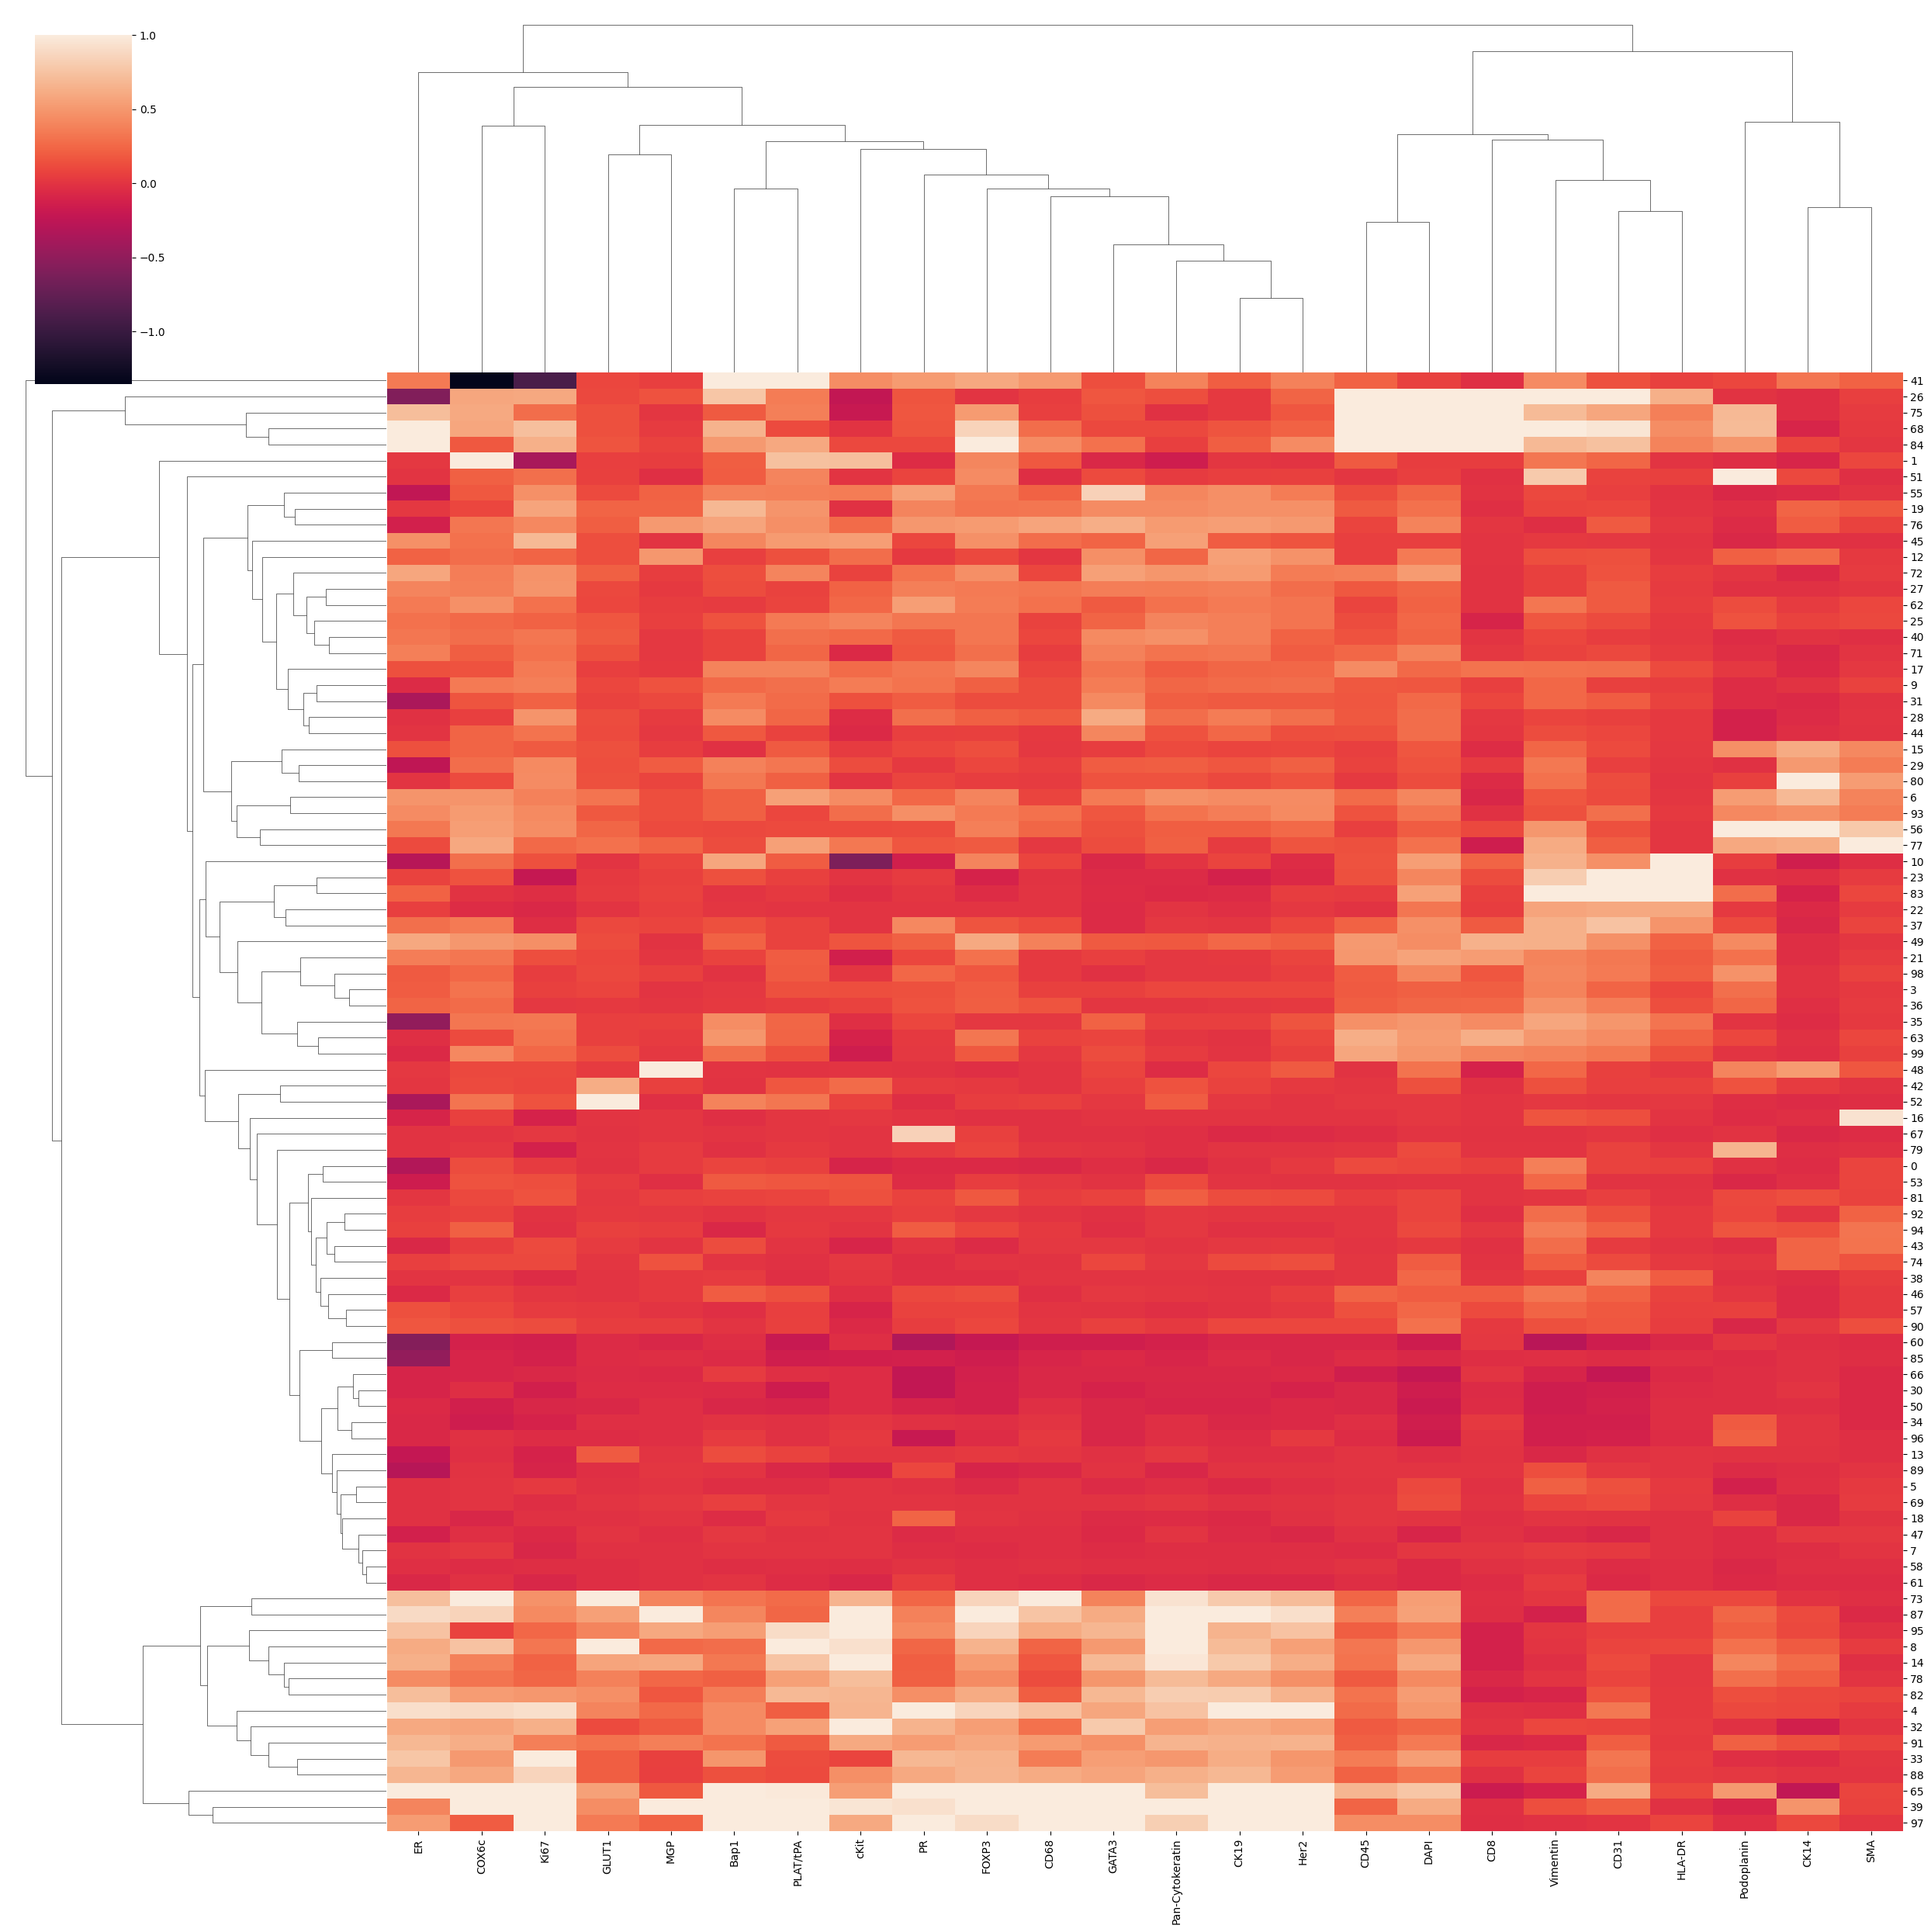

In [53]:
hm = sns.clustermap(clean, figsize=(25, 25))
plt.savefig('/data/estorrs/mushroom/data/projects/testing/mushroom/HT397B1_vae_vq_codex_cb30/figures/exp_hm.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 16 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'period', 's', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 86]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 16 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'period', 's', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs

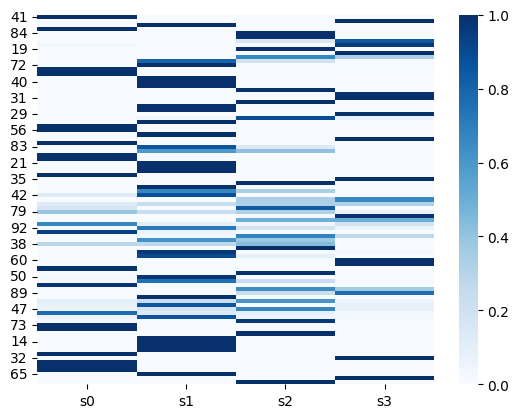

In [54]:
count_df = count_df.loc[exp_df.index[hm.dendrogram_row.reordered_ind].to_list()]
sns.heatmap(count_df.iloc[:, :-1], cmap='Blues')
plt.savefig('/data/estorrs/mushroom/data/projects/testing/mushroom/HT397B1_vae_vq_codex_cb30/figures/slide_hm.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 18 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'eight', 'five', 'four', 'l', 'nine', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 68, 79, 82, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 18 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'eight', 'five', 'four', 'l', 'nine', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'three', 'two', 'zero']
INFO:fontTool

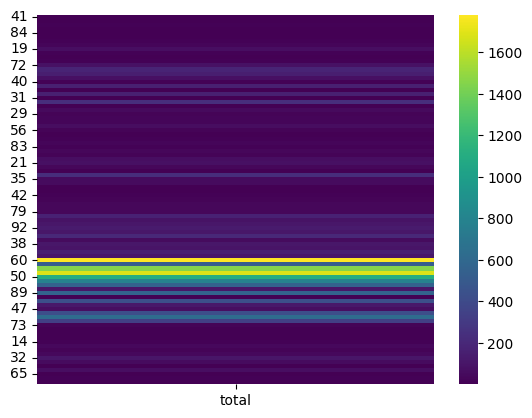

In [55]:
sns.heatmap(count_df.iloc[:, -1:], cmap='viridis')
plt.savefig('/data/estorrs/mushroom/data/projects/testing/mushroom/HT397B1_vae_vq_codex_cb30/figures/total_hm.pdf')

In [ ]:
cuts = np.linspace(.0, 1., 20)
utils.display_thresholds(cuts, cluster_ids, exp_df, 'SMA')

In [169]:
from sklearn.cluster import AgglomerativeClustering
dist = .5
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist).fit(
    clean.values
)
# clustering = AgglomerativeClustering(n_clusters=10, distance_threshold=None).fit(exp.values)
cluster_to_label = {c:l for c, l in zip(clean.index.to_list(), clustering.labels_)}
neigh_ids = np.vectorize(cluster_to_label.get)(cluster_ids)
len(np.unique(neigh_ids))

30

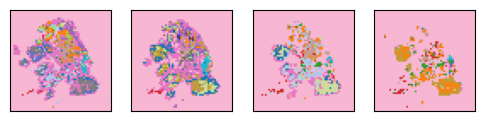

In [170]:
fig, axs = plt.subplots(ncols=neigh_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(neigh_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

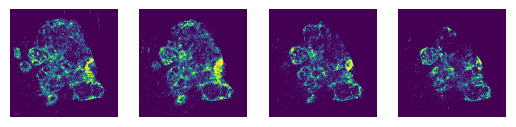

In [25]:
x = mushroom.true_imgs[:, mushroom.learner.channels.index('HLA-DR')]
fig, axs = plt.subplots(ncols=x.shape[0])
for img, ax in zip(x, axs):
    ax.imshow(img>15.)
    ax.axis('off')

In [84]:
cluster_ids.shape

(4, 60, 60)

In [97]:
pool = []
for i in range(cluster_ids.shape[0] - 1):
    pairs = rearrange(cluster_ids[i:i+2], 'n h w -> (h w) n')
    pairs = [tuple(sorted([x1, x2])) for x1, x2 in pairs]
    pool += pairs
counts = Counter(pool)

overlap_df = pd.DataFrame(data=np.zeros((mushroom.learner.sae.vq.codebook.shape[0], )))


In [89]:
arr[:, 0, 0]

array([32, 61, 62, 64])

In [90]:
cluster_ids[:, 0, 0]

array([32, 61, 64, 62])

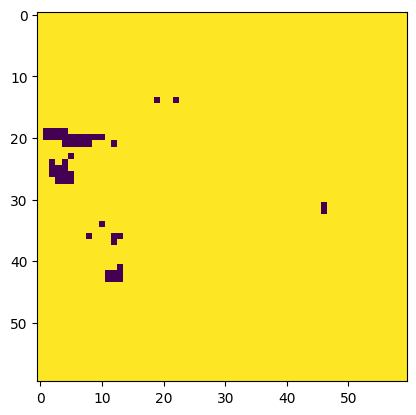

In [93]:
plt.imshow(np.sum(arr > 0, axis=0))

#### cluster distance based

In [63]:
clusters = exp_df.sort_values('HLA-DR', ascending=False).index.to_list()[:10]
clusters

[28, 86, 57, 19, 90, 25, 98, 97, 12, 69]

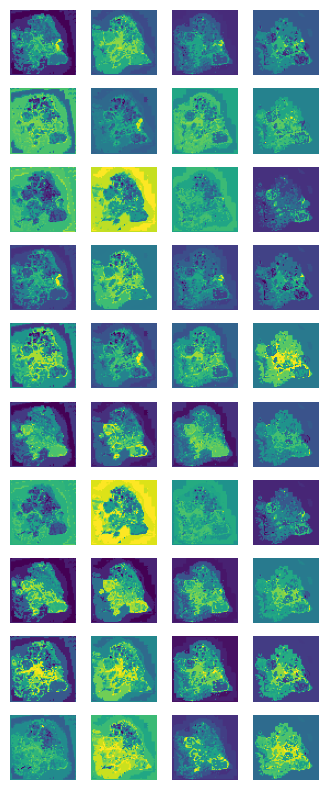

In [67]:
nrows, ncols = len(clusters), mushroom.cluster_sims.shape[0]
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
for c in range(ncols):
    for r, cluster in enumerate(clusters):
        ax = axs[r, c]
        ax.imshow(mushroom.cluster_sims[c, cluster])
        ax.axis('off')
        ax.set_ylabel(cluster, rotation=90)


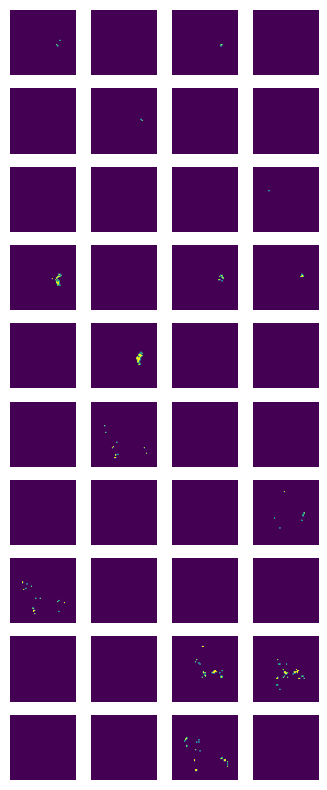

In [68]:
nrows, ncols = len(clusters), cluster_ids.shape[0]
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
for c in range(ncols):
    for r, cluster in enumerate(clusters):
        ax = axs[r, c]
        ax.imshow(cluster_ids[c]==cluster)
        ax.axis('off')
        ax.set_ylabel(cluster, rotation=90)


In [178]:
mushroom.true_imgs.shape

torch.Size([4, 24, 1920, 1920])

In [33]:
section_positions = [0, 10]
volume = utils.get_interpolated_volume(cluster_ids, section_positions)
volume.shape

(10, 60, 60)

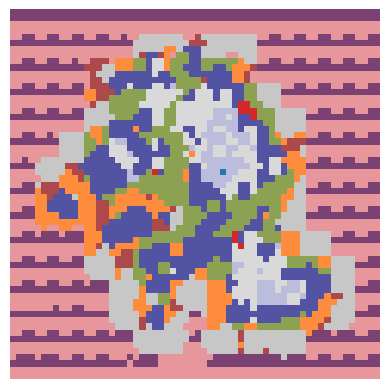

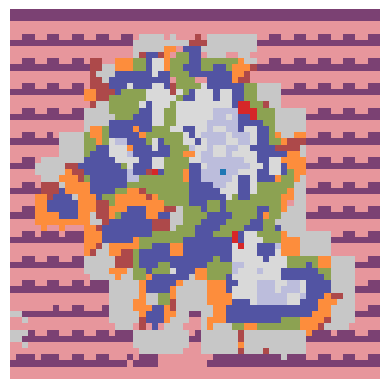

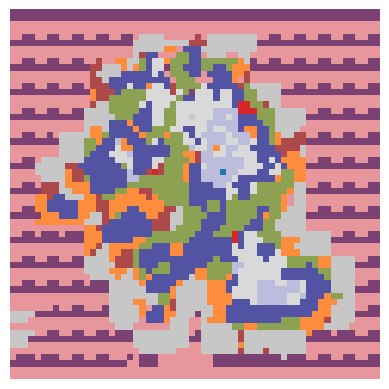

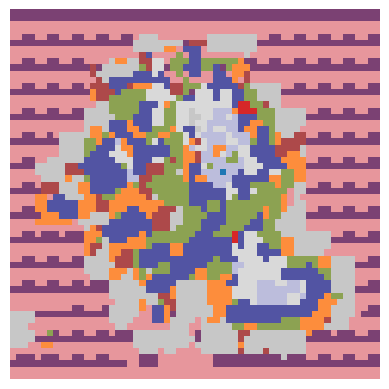

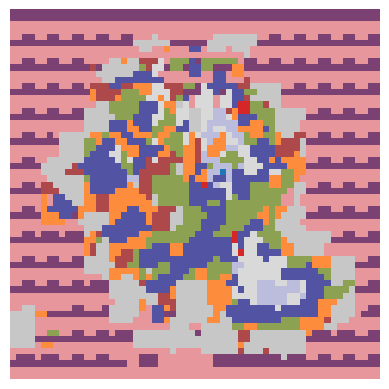

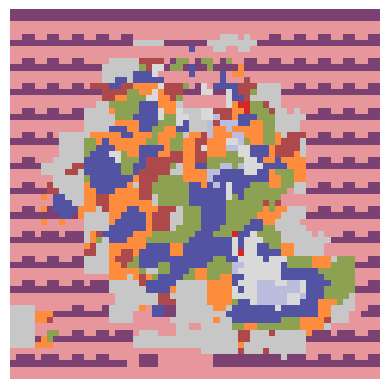

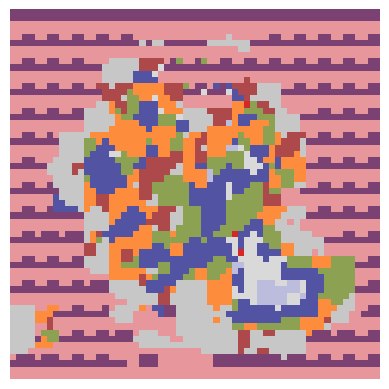

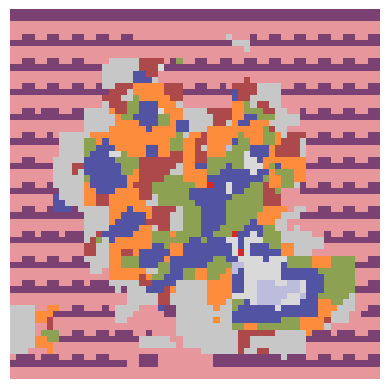

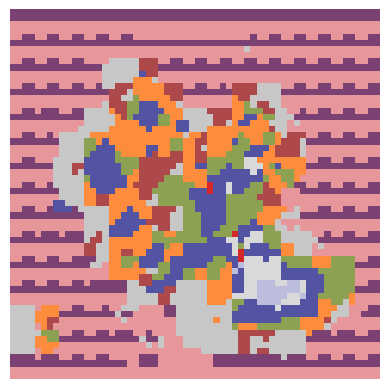

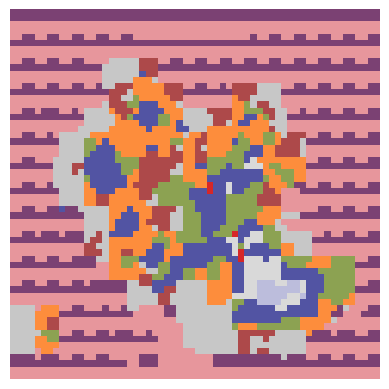

In [35]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c') + sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
for x in volume:
    x = display_labeled_as_rgb(x, cmap=cmap)
    plt.imshow(x)
    plt.axis('off')
    plt.show()

In [36]:
section_positions = [0, 10]
cluster_sims = rearrange(mushroom.cluster_sims.numpy(), 'n c h w -> c n h w')
volume = utils.get_interpolated_volume(cluster_sims, section_positions, method='linear')
volume.shape

(100, 10, 60, 60)

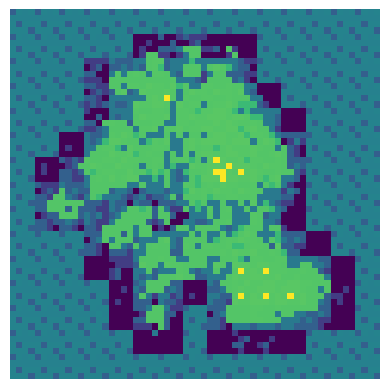

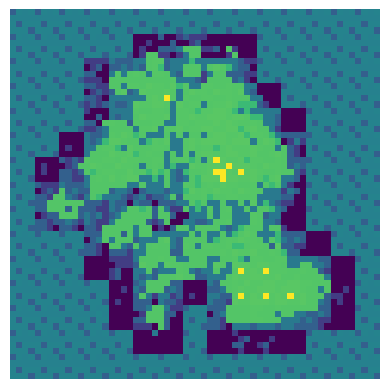

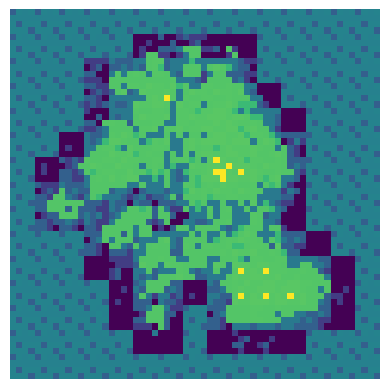

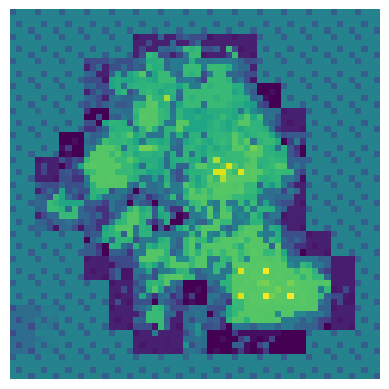

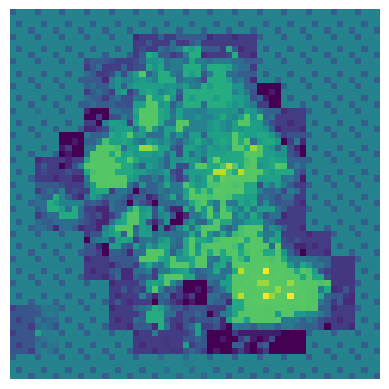

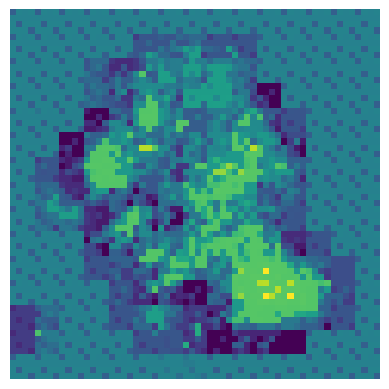

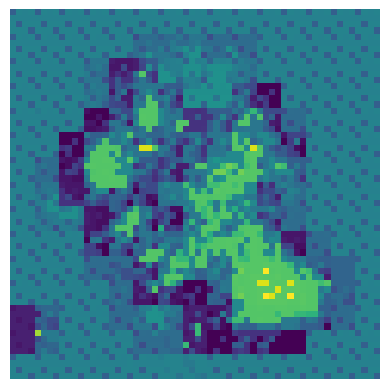

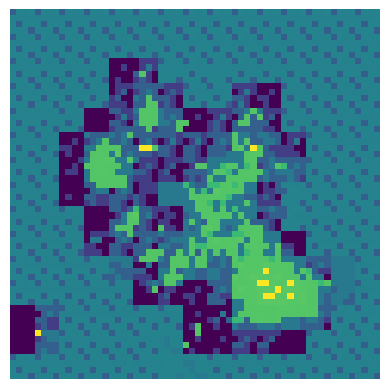

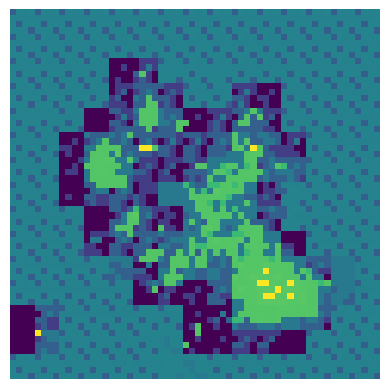

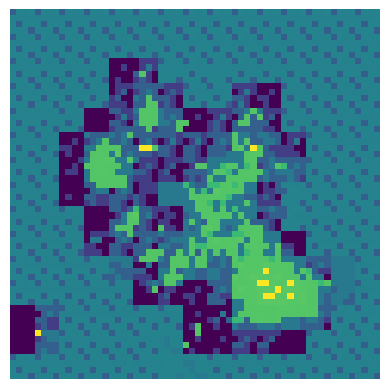

In [38]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c') + sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
for i in range(volume.shape[1]):
    plt.imshow(volume[0, i])
    plt.axis('off')
    plt.show()